In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
df.head(3)

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping


In [5]:
# cleaning and removing stop words
lemmatizer = WordNetLemmatizer()
clean_text = []
for text in df['question']:
    words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))

len(clean_text)
df['clean_text'] = clean_text
df.head()

,question,topic,clean_text
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,hi sign email list select get email exclusivel...
1,I'm going to be out of the country for about a...,Shipping,going country week travel going getting animal...
2,I was wondering if you'd be able to overnight ...,Shipping,wondering able overnight jacket item trenton nj
3,The Swingline electronic stapler (472555) look...,Shipping,swingline electronic stapler look really great...
4,I think this cosmetic bag would work great for...,Shipping,think cosmetic bag would work great however kn...


In [6]:
df.groupby('topic').clean_text.count()

topic
Omnichannel               450
Product Availability      833
Product Comparison        806
Product Specifications    839
Returns & Refunds         768
Sales/Promotions          505
Shipping                  799
Name: clean_text, dtype: int64

In [7]:
# Split data into train and test and create TF-IDF vectorizer

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['topic'], test_size=0.2, random_state=42)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

The text needs to be transformed to vectors so as the algorithms will be able to make predictions. We will use the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents

In [8]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['clean_text'])
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [9]:
df['topic_id'] = df['topic'].factorize()[0]
topic_id_df = df[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

Implementation of Naive Bayes, Random Forests and Neural Network Clasifiers.

In [10]:
# Naive Bayes Classifier with default parameters

start_time = time.time() 
nbModel = MultinomialNB()
nbModel.fit(xtrain_tfidf, y_train)  
nb_predict_y = nbModel.predict(xtest_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  2.018544409010145e-06  seconds


In [11]:
# Random Forest (Bagging Model) Classifier

start_time = time.time() 
rfModel = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)
rfModel.fit(xtrain_tfidf, y_train)  
rf_predict_y = rfModel.predict(xtest_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  0.000726381672753228  seconds


Third classfier model used is Neural Network Classifier. A neural network includes weights, a score function and a loss function. A neural network learns in a feedback loop, it adjusts its weights based on the results from the score function and the loss function. 

In [12]:
# Neural Network Classifier

start_time = time.time() 
nnModel = MLPClassifier(alpha = 1, hidden_layer_sizes=(120,), learning_rate='adaptive')
nnModel.fit(xtrain_tfidf, y_train)  
nn_predict_y = nnModel.predict(xtest_tfidf)
nn_accuracy = accuracy_score(y_test, nn_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  0.005792956815825569  seconds


Naive Bayes Classifier is fasted and Neural network is slowest amoung these three classifier.

In [13]:
print('Naive Bayes: {:.3f}'.format(nb_accuracy))
print('Random Forests: {:.3f}'.format(rf_accuracy))
print('Neural Network: {:.3f}'.format(nn_accuracy))

Naive Bayes: 0.942
Random Forests: 0.972
Neural Network: 0.955


Random Forest has maximum accuracy of 97.2% and Naive Bayes has least 94.2%. Neural network has accuracy of 95.5%.

*   List item
*   List item



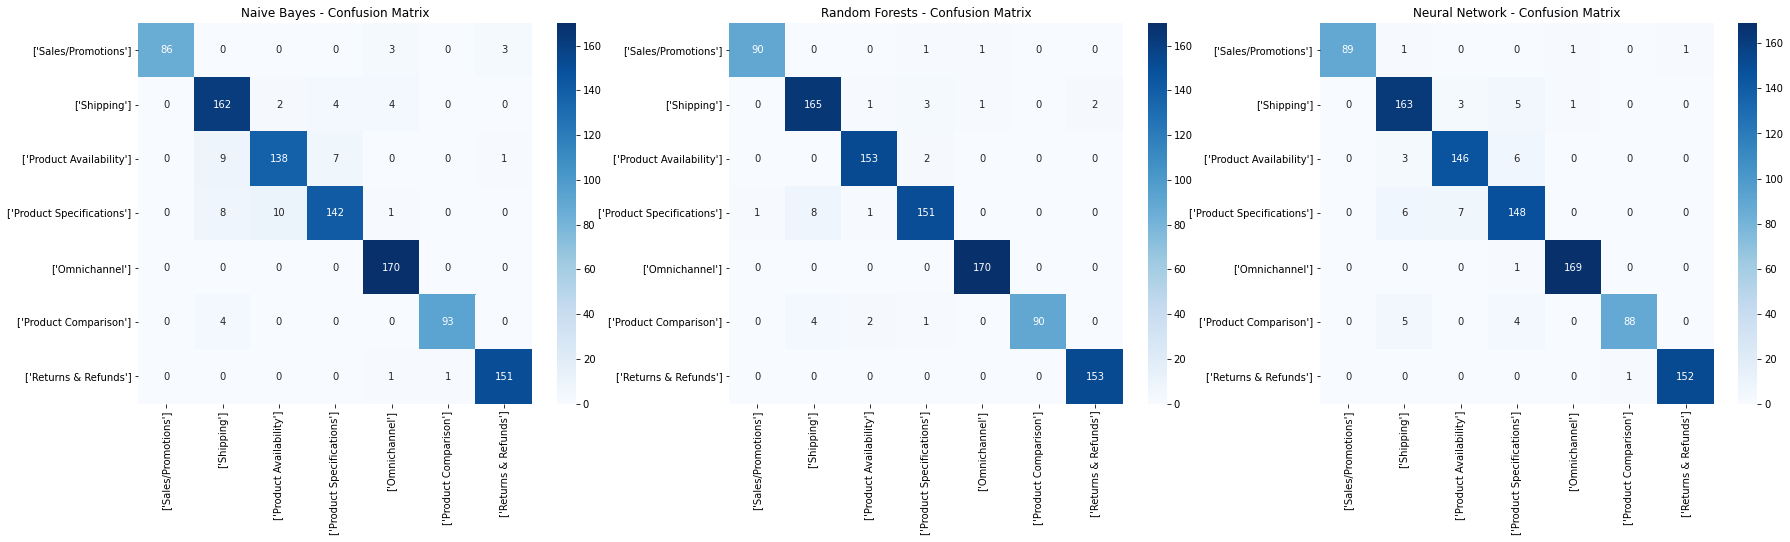

In [17]:
nb = confusion_matrix(y_test, nbModel.predict(xtest_tfidf))
rf = confusion_matrix(y_test, rfModel.predict(xtest_tfidf))
nn = confusion_matrix(y_test, nnModel.predict(xtest_tfidf))

plt.figure(figsize=(30,7))
plt.subplot(131)
sns.heatmap(nb, annot=True, fmt='d', cmap="Blues",
                xticklabels=topic_id_df[['topic']].values, 
                yticklabels=topic_id_df[['topic']].values)
plt.title('Naive Bayes - Confusion Matrix')

plt.subplot(132)
sns.heatmap(rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=topic_id_df[['topic']].values, 
                yticklabels=topic_id_df[['topic']].values)
plt.title('Random Forests - Confusion Matrix')

plt.subplot(133)
sns.heatmap(nn, annot=True, fmt='d', cmap="Blues",
                xticklabels=topic_id_df[['topic']].values, 
                yticklabels=topic_id_df[['topic']].values)
plt.title('Neural Network - Confusion Matrix')

plt.show()

A confusion matrix is a table that is used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

**Naive Bayes** predicted Sales/Promotions 86 times correctly however made 3 predictions as Omnichannel and 3 as Returns & Refunds.

**Random Forest** made 90 predictions of Sales/Promotions accurately and 1 of Product Specification and Omnichannel each.

**Neural Network** predicts 89 Sales/Promotions accurately and 1 of Shipping, Omnichannel and Returns & Refunds each. 

In [18]:
print('Naive Bayes classifier:')
print(classification_report(y_test, nbModel.predict(xtest_tfidf)))
print('***************************************************************************')
print('Random Forests classifier')
print(classification_report(y_test, rfModel.predict(xtest_tfidf)))
print('***************************************************************************')
print('Neural Network classifier')
print(classification_report(y_test, nnModel.predict(xtest_tfidf)))

Naive Bayes classifier:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        92
           1       0.89      0.94      0.91       172
           2       0.92      0.89      0.90       155
           3       0.93      0.88      0.90       161
           4       0.95      1.00      0.97       170
           5       0.99      0.96      0.97        97
           6       0.97      0.99      0.98       153

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.94      0.94      0.94      1000

***************************************************************************
Random Forests classifier
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       0.93      0.96      0.95       172
           2       0.97      0.99      0.98       155
           3       0.96      0.94      0.95       161
      

The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem.

**Precision** is a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. 

**Recall** is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. 

The **F1 score** is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 

**Support** is the number of actual occurrences of the class in the specified dataset. 

In [29]:
# Sample Prediction example

new_text = ["I want to buy either the Ellison recliner 536342 or the Dalton recliner 174474 but wanted to ask you which takes up less space when fully reclined? What kind of materials are both made of?"]
text_features = tfidf_vect.transform(new_text)
nbPredict = nbModel.predict(text_features)
rfPredict = rfModel.predict(text_features)
nnPredict = nnModel.predict(text_features)
print('Naive Bayes Prediction: ', id_to_topic[rfPredict[0]])
print('Random Forest Prediction: ', id_to_topic[rfPredict[0]])
print('Neural Network Prediction: ', id_to_topic[nnPredict[0]])

Naive Bayes Prediction:  Product Availability
Random Forest Prediction:  Product Availability
Neural Network Prediction:  Product Availability
